# Outlier Detection Approaches

We will be using iris dataset as data and apply some methods

## Lib importation

In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import qmc
import statsmodels.api as sm
from pymoo.problems import get_problem
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## Statistical Diagnostics

On this statistical diagnostics we are going to implement residuals, studentized residuals, leverage, DFFITS & Cook’s Distance


     residuals  studentized_residuals  leverage    dffits  cooks_distance
141   0.689744               2.291006  0.057232  0.564472        0.077405
134  -0.640237              -2.130018  0.064736 -0.560387        0.076652
106  -0.828164              -2.727692  0.027227 -0.456337        0.049861
135   0.845696               2.780593  0.021968  0.416728        0.041502
14    0.600992               1.969489  0.040304  0.403608        0.039937


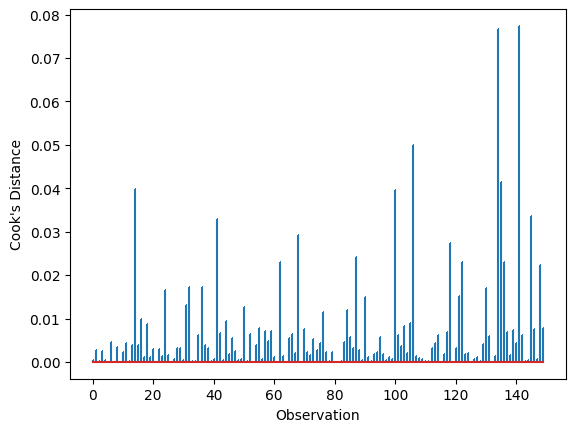

In [3]:
# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# For demonstration, let's fit a linear model to predict sepal length from other features
X_model = X.drop(columns=['sepal length (cm)'])
y_model = X['sepal length (cm)']

# Add constant for intercept
X_model_const = sm.add_constant(X_model)

# Fit OLS model
model = sm.OLS(y_model, X_model_const).fit()

# Get influence measures
influence = model.get_influence()
summary_frame = influence.summary_frame()

# Add diagnostics to DataFrame
X['residuals'] = model.resid
X['studentized_residuals'] = summary_frame['student_resid']
X['leverage'] = summary_frame['hat_diag']
X['dffits'] = summary_frame['dffits']
X['cooks_distance'] = summary_frame['cooks_d']

# Show top outliers by Cook's Distance
outliers = X.sort_values('cooks_distance', ascending=False).head()
print(outliers[['residuals', 'studentized_residuals', 'leverage', 'dffits', 'cooks_distance']])

# Plot Cook's Distance
plt.stem(np.arange(len(X)), X['cooks_distance'], markerfmt=",")
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

### Interquartile Range (IQR)

In [4]:
def calculate_iqr(data):
    """Calculate Interquartile Range (IQR) for outlier detection."""
    data_array = np.array(data)

    q1 = np.percentile(data_array, 25)
    q3 = np.percentile(data_array, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return q1, q3, lower_bound, upper_bound


def detect_outliers_iqr(data):
    """Detect outliers using IQR method."""
    data_array = np.array(data)
    q1, q3, lower_bound, upper_bound = calculate_iqr(data_array)

    is_outlier = (data_array < lower_bound) | (data_array > upper_bound)
    outliers = data_array[is_outlier]
    
    return outliers, is_outlier

### IQR Test on "LotArea" attribute of "House Pricing Dataset"

In [5]:
train_df = pd.read_csv('train.csv')

q1, q3, lower_bound, upper_bound = calculate_iqr(train_df['LotArea'])
outliers, is_outlier_mask = detect_outliers_iqr(train_df['LotArea'])

print(f"LotArea Statistics:")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")
print(f"Number of outliers detected: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers) / len(train_df)) * 100:.2f}%")

LotArea Statistics:
Q1 (25th percentile): 7553.50
Q3 (75th percentile): 11601.50
Lower bound for outliers: 1481.50
Upper bound for outliers: 17673.50
Number of outliers detected: 69
Percentage of outliers: 4.73%


### Comparing Feature before and after outlier detection

In [6]:
train_df_clean = train_df[~is_outlier_mask]
print(f"\nOriginal dataset size: {len(train_df)}")
print(f"Clean dataset size after removing outliers: {len(train_df_clean)}")


Original dataset size: 1460
Clean dataset size after removing outliers: 1391


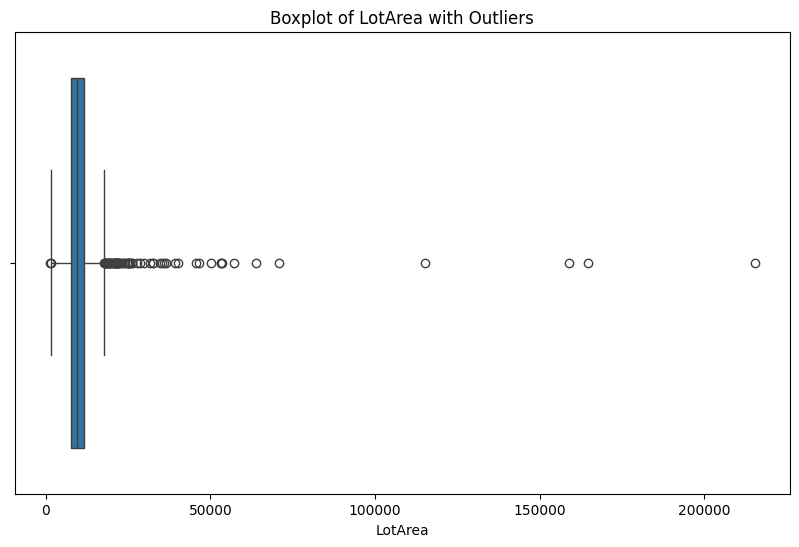

In [6]:
# Boxplot to visualize the distribution and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['LotArea'])
plt.title('Boxplot of LotArea with Outliers')
plt.xlabel('LotArea')
plt.show()

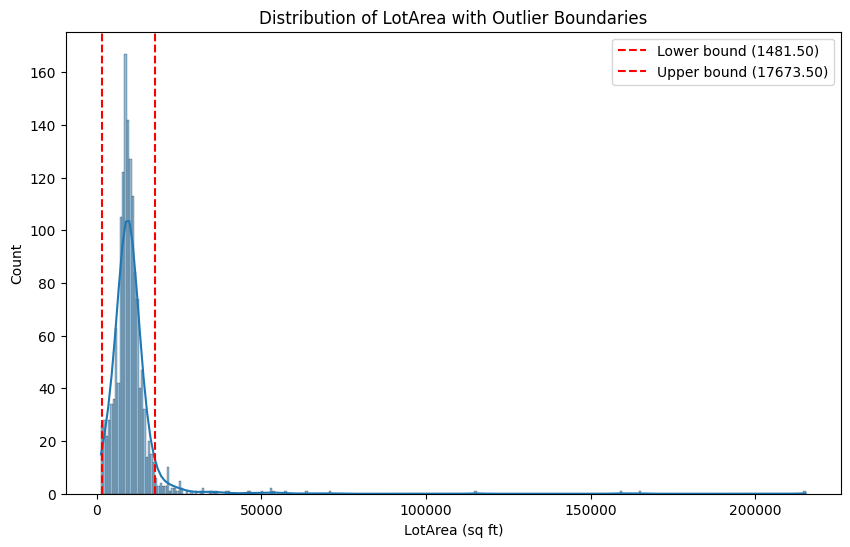

In [7]:
# Histogram to show the distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea (sq ft)')
plt.legend()
plt.show()

In [8]:
# Compare statistics before and after outlier removal
print("\nStatistics before outlier removal:")
print(train_df['LotArea'].describe())
print("\nStatistics after outlier removal:")
print(train_df_clean['LotArea'].describe())


Statistics before outlier removal:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Statistics after outlier removal:
count     1391.000000
mean      9272.537024
std       3196.732418
min       1491.000000
25%       7429.000000
50%       9286.000000
75%      11231.500000
max      17671.000000
Name: LotArea, dtype: float64


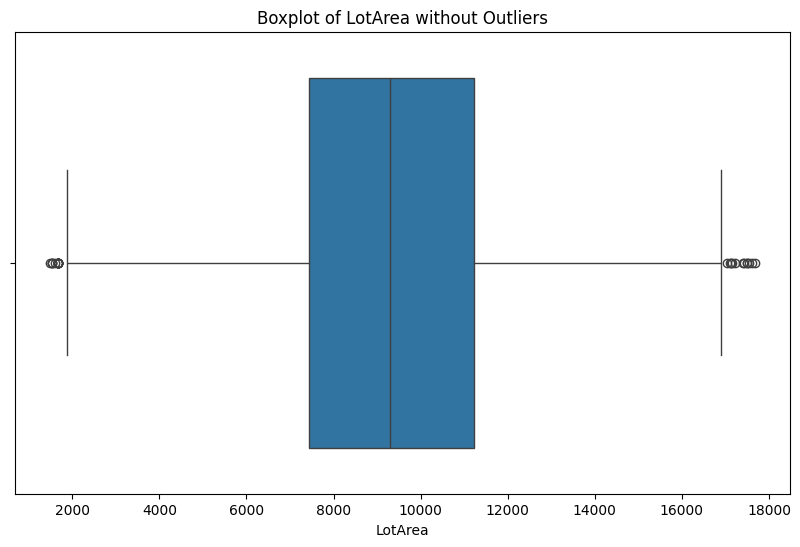

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_clean['LotArea'])
plt.title('Boxplot of LotArea without Outliers')
plt.xlabel('LotArea')
plt.show()

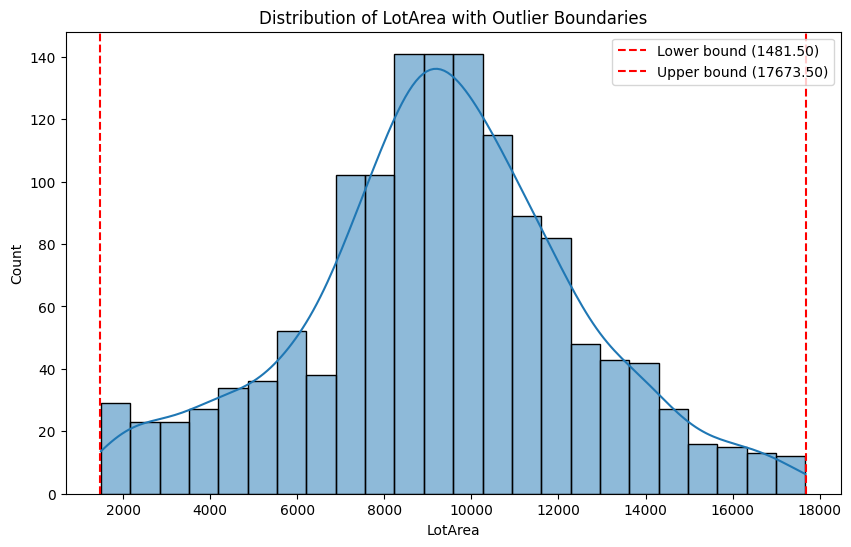

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df_clean['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea')
plt.legend()
plt.show()

## Semi-supervised and Unsupervised methods

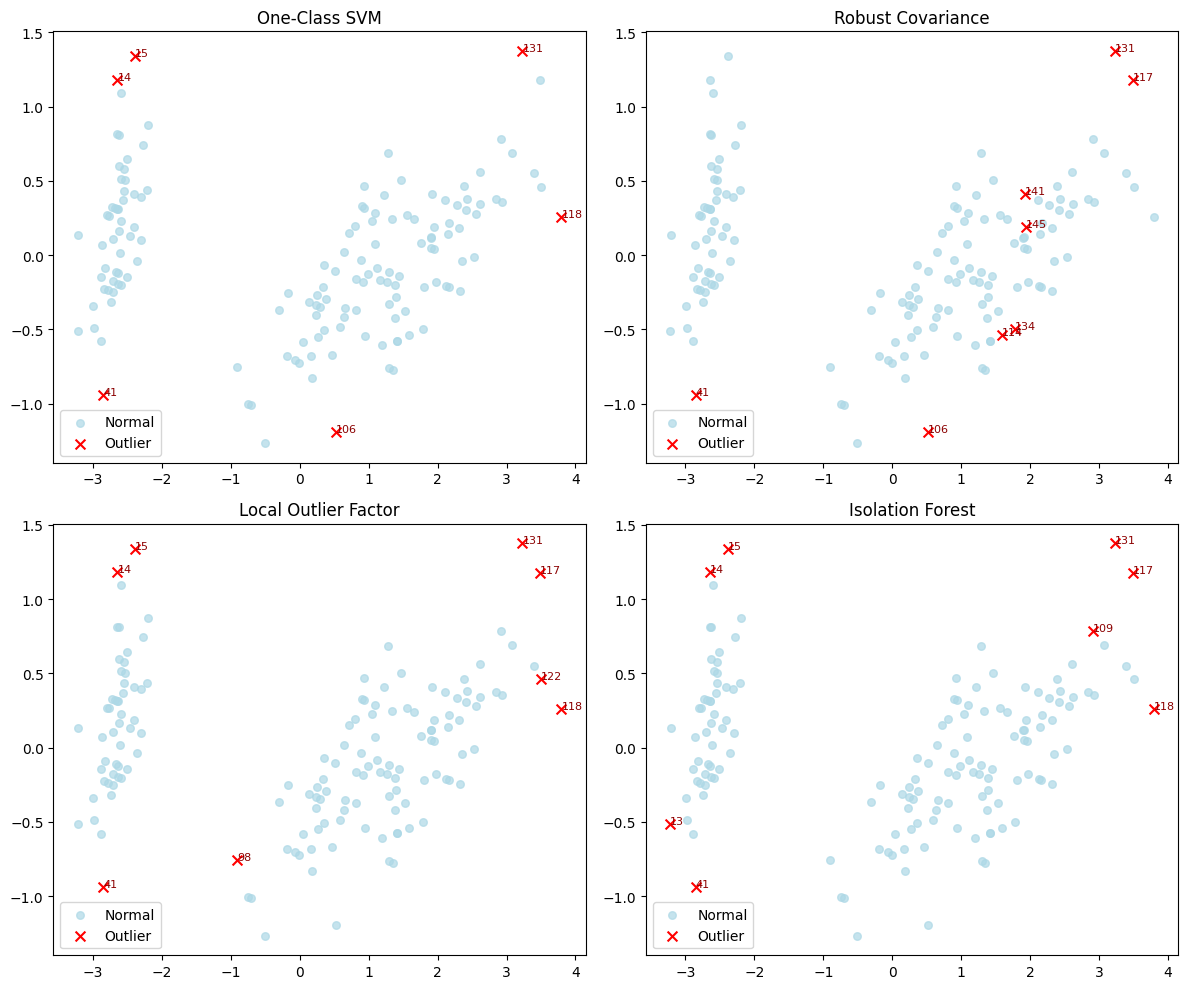

In [ ]:

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target 

# Dimensionality reduction (2D PCA projection)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1), 
    "Robust Covariance": EllipticEnvelope(contamination=0.05, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.05, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42)
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)
    
    # Standardize labels: anomaly = -1, normal = 1
    anomalies = (y_pred == -1)
    
    # Plot
    axs[i].scatter(X_2d[~anomalies, 0], X_2d[~anomalies, 1],
                   c="lightblue", label="Normal", s=30, alpha=0.7)
    axs[i].scatter(X_2d[anomalies, 0], X_2d[anomalies, 1],
                   c="red", label="Outlier", s=50, marker="x")
    
    # Annotate anomaly points
    for idx in np.where(anomalies)[0]:
        #print(f"Anomaly detected at index {idx} with coordinates {X_2d[idx]}")
        axs[i].annotate(str(idx), (X_2d[idx, 0], X_2d[idx, 1]),
                        fontsize=8, color="darkred")
    
    axs[i].set_title(name)
    axs[i].legend()

plt.tight_layout()
plt.show()


Subset shapes: (100, 4) (100,)
Normal (Virginica): 50, Outlier (Versicolor): 50


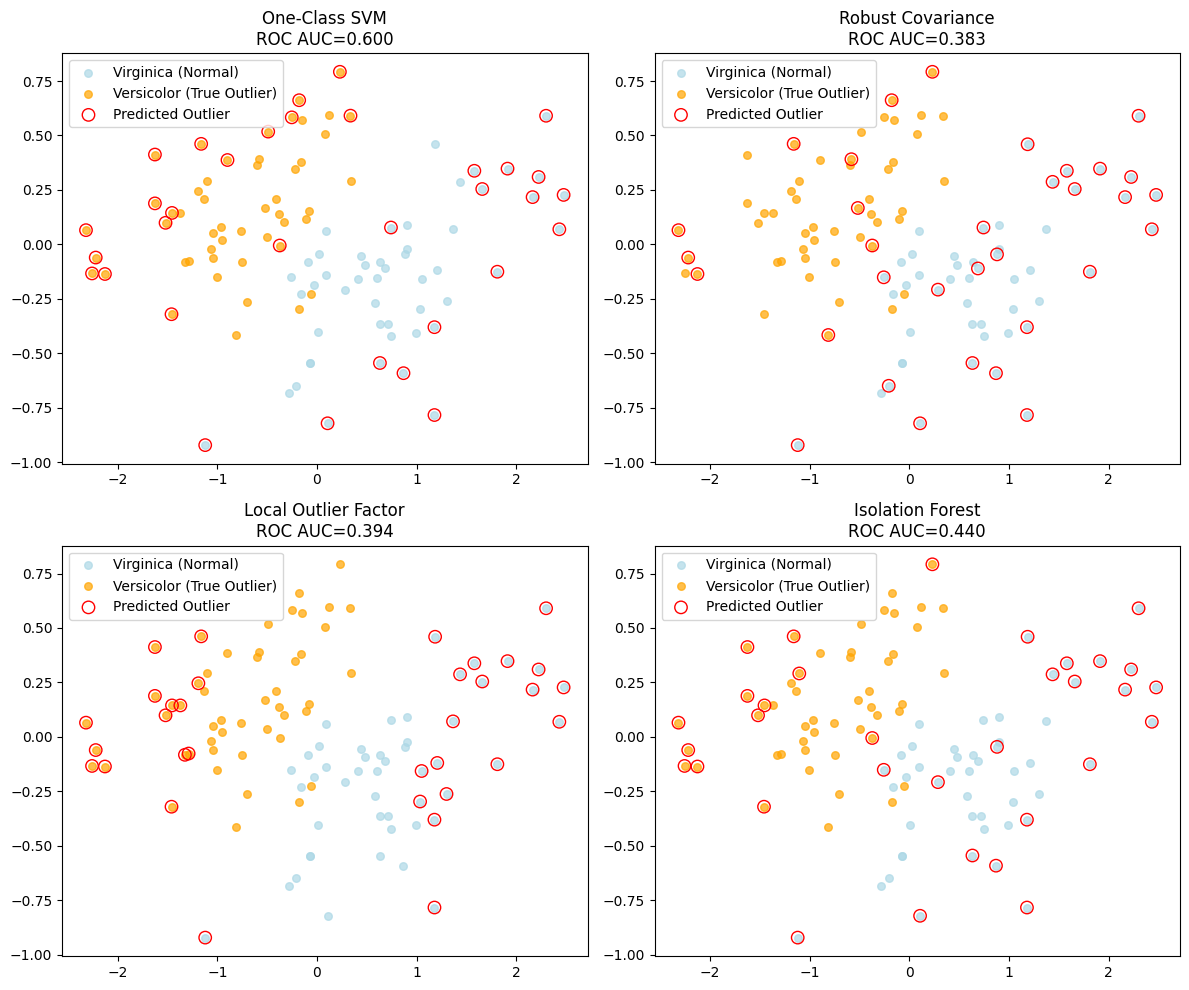

ROC AUC results :
One-Class SVM       : 0.600
Robust Covariance   : 0.383
Local Outlier Factor: 0.394
Isolation Forest    : 0.440


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

# Load dataset (only Versicolor & Virginica)
iris = load_iris()
X = iris.data
y = iris.target

# Keeping only classes 1 (versicolor) and 2 (virginica)
mask = (y != 0)
X = X[mask]
y = y[mask]

# treat Virginica (class=2) as "normal" (0), Versicolor (class=1) as "outlier" (1)
y_binary = (y == 1).astype(int)

print("Subset shapes:", X.shape, y_binary.shape)
print(f"Normal (Virginica): {np.sum(y_binary==0)}, Outlier (Versicolor): {np.sum(y_binary==1)}")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "Robust Covariance": EllipticEnvelope(contamination=0.33, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=int(X.shape[0] * y_binary.mean()), contamination=0.33, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=0.33, random_state=42)
}

# Fit, predict & evaluate
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

results_auc = {}

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        model.fit(X)  
        scores = -model.negative_outlier_factor_ 
        #scores = model[-1].negative_outlier_factor_
    else:
        model.fit(X)
        scores = -model.decision_function(X)
    
    # Predict anomalies
    preds = (scores > np.percentile(scores, 67)).astype(int)
    
    # ROC AUC evaluation
    auc = roc_auc_score(y_binary, scores)
    results_auc[name] = auc
    
    # Visualization
    axs[i].scatter(X_2d[y_binary == 0, 0], X_2d[y_binary == 0, 1],
                   c="lightblue", label="Virginica (Normal)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[y_binary == 1, 0], X_2d[y_binary == 1, 1],
                   c="orange", label="Versicolor (True Outlier)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1],
                   facecolors='none', edgecolors='red', marker="o", s=80,
                   label="Predicted Outlier")
    
    axs[i].set_title(f"{name}\nROC AUC={auc:.3f}")
    axs[i].legend(loc="best")

plt.tight_layout()
plt.show()

# Print AUC scores summary
print("ROC AUC results :")
for name, auc in results_auc.items():
    print(f"{name:20s}: {auc:.3f}")


## Outlier Detection on Kursawe Benchmark

Problem name: <bound method Problem.name of <pymoo.problems.multi.kursawe.Kursawe object at 0x0000015CF1915050>>
Number of variables: 3
Lower bounds: [-5. -5. -5.]
Upper bounds: [5. 5. 5.]
Number of objectives: 2
Number of constraints: 0
X first values: [[ 2.9880685   4.69612913 -3.3125323 ]
 [-4.20916425  2.41793887  0.54340893]
 [-4.93476009 -3.755566   -3.67275102]
 [ 1.26335688 -2.35968445 -3.13473903]
 [-3.65408112  0.00771971  3.07661296]]
X shape: (200, 3) y shape: (200,)
Injected 20 outliers


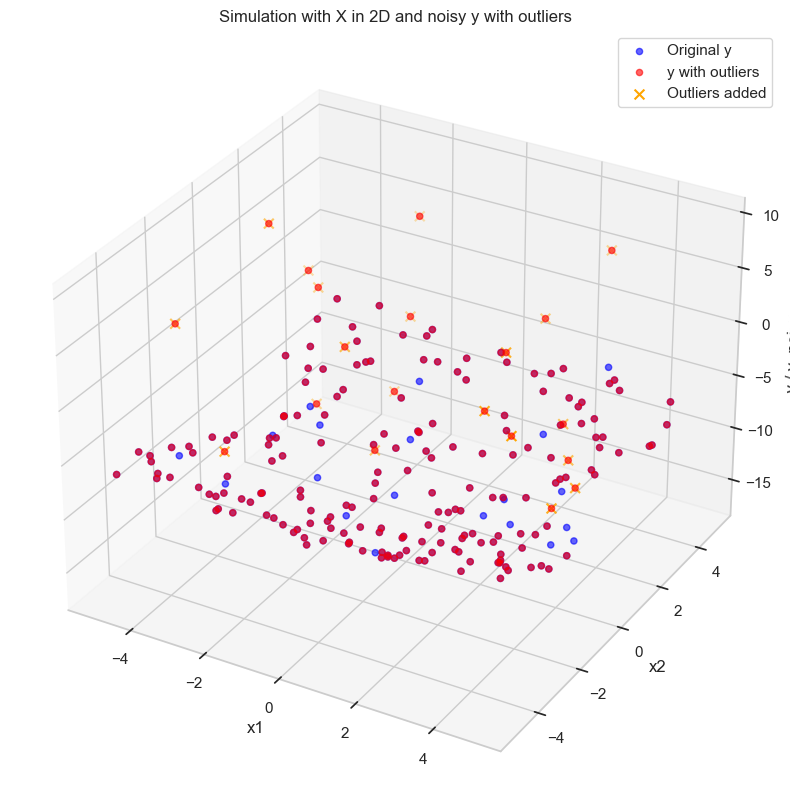


Detection summary (vs injected ground truth):
IsolationForest     flagged= 20 | TP=  1  FP= 19  FN= 19
LocalOutlierFactor  flagged= 20 | TP=  0  FP= 20  FN= 20
OneClassSVM         flagged= 28 | TP=  4  FP= 24  FN= 16
EllipticEnvelope    flagged= 20 | TP=  0  FP= 20  FN= 20


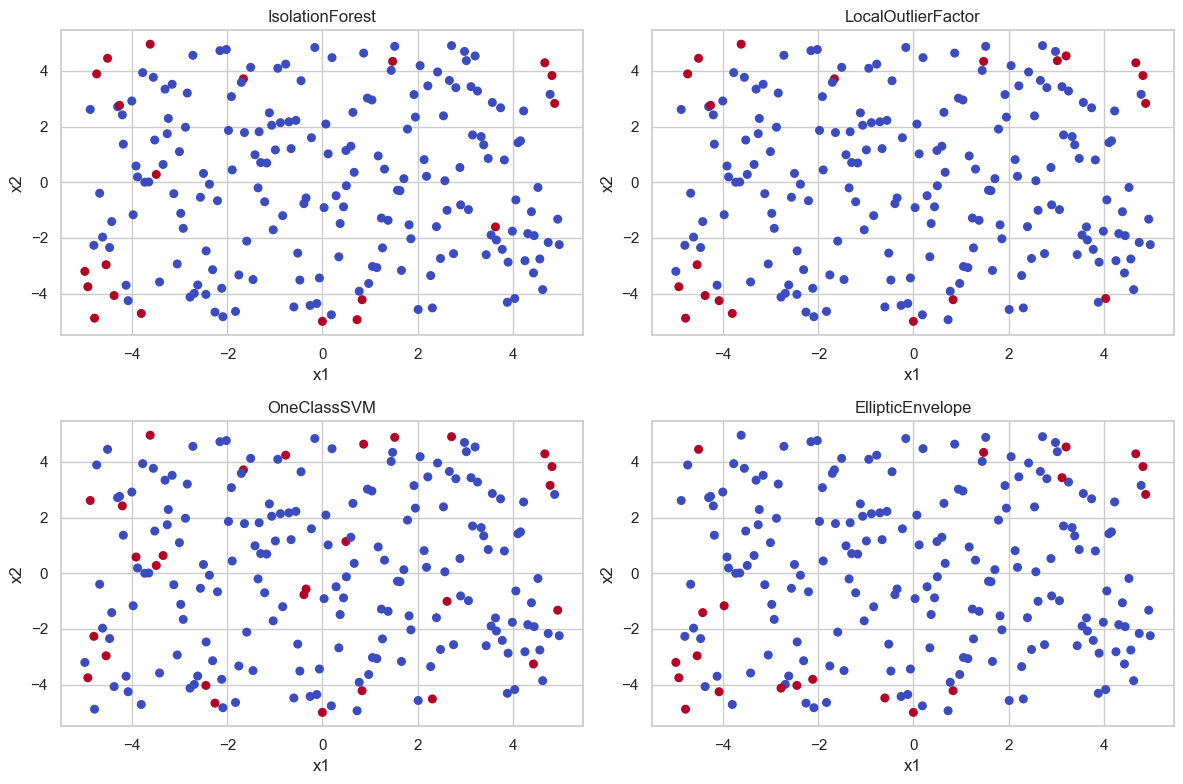

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from pymoo.problems import get_problem
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

sns.set(style="whitegrid")

# Loading Kursawe problem (3D input, 2 objectives)
problem = get_problem("kursawe")

print("Problem name:", problem.name)
print("Number of variables:", problem.n_var)
print("Lower bounds:", problem.xl)
print("Upper bounds:", problem.xu)
print("Number of objectives:", problem.n_obj)
print("Number of constraints:", problem.n_constr)

N = 200  # Number of samples

# Generating random design of experiments
#X = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))

# Generating latin hypercube samples
sampling = LatinHypercubeSampling()
X = sampling.do(problem, N).get("X") 

F = problem.evaluate(X)

# Use only the first objective for simplicity
y = F[:, 0]
print("X first values:", X[:5])
print("X shape:", X.shape, "y shape:", y.shape)

# Inject artificial outliers in y
n_outliers = int(0.10 * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()
y_noisy[outlier_idx] += np.random.normal(10, 5, size=n_outliers)

mask_injected = np.zeros(N, dtype=bool)
mask_injected[outlier_idx] = True


print(f"Injected {n_outliers} outliers")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
 
# Visualizing points with outliers
ax.scatter(X[:, 0], X[:, 1], y, label="Original y", color="blue", alpha=0.6)  
ax.scatter(X[:, 0], X[:, 1], y_noisy, label="y with outliers", color="red", alpha=0.6)
ax.scatter(X[outlier_idx, 0], X[outlier_idx, 1], y_noisy[outlier_idx], 
           color="orange", label="Outliers added", s=50, marker="x")
 
ax.set_title("Simulation with X in 2D and noisy y with outliers")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y / y_noisy")
ax.legend()
plt.show()

def report(name, preds, mask_injected):
    mask = preds == -1 # outliers detected
    tp = np.sum(mask & mask_injected)
    fp = np.sum(mask & ~mask_injected)
    fn = np.sum(~mask & mask_injected)
    print(f"{name:18s}  flagged={mask.sum():3d} | TP={tp:3d}  FP={fp:3d}  FN={fn:3d}")



# Apply outlier detection methods
detectors = {
    "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.1, random_state=42)
}

results = {}
for name, clf in detectors.items():
    if name == "LocalOutlierFactor":
        preds = clf.fit_predict(X)
    else:
        preds = clf.fit(X).predict(X)
    results[name] = preds

print("\nDetection summary (vs injected ground truth):")
for name, preds in results.items():
    report(name, preds, mask_injected)


# Visualization after applying outlier detection methods
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
#axs = [fig.add_subplot(2, 2, i+1, projection='3d') for i in range(4)]

for i, (name, preds) in enumerate(results.items()):
    axs[i].scatter(X[:, 0], X[:, 1], c=(preds == -1), cmap="coolwarm", s=30)
    axs[i].set_title(name)
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("x2")

plt.tight_layout()
plt.show()





=== Benchmark Results on Kursawe ===
               Method  TP  FP  FN       AUC
0     IsolationForest   3  21  21  0.524457
1  LocalOutlierFactor   5  19  19  0.569746
2         OneClassSVM   2  22  22  0.501812
3    RobustCovariance   4  20  20  0.547101


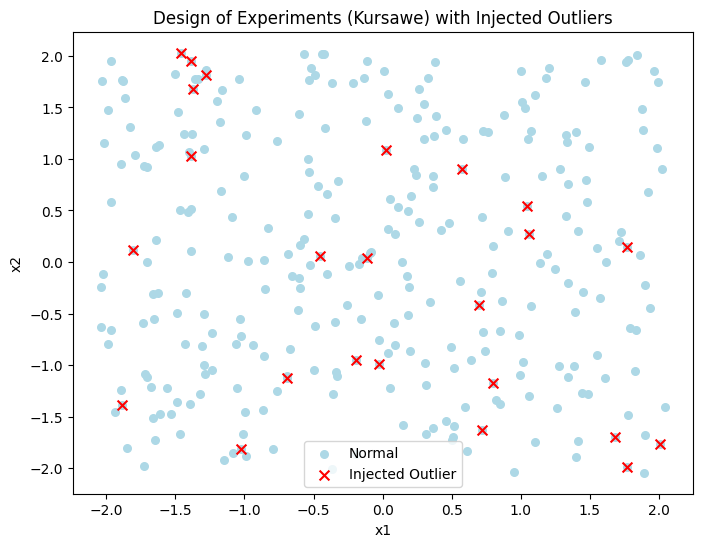

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score
from pymoo.problems import get_problem

# Select Benchmark (Kursawe)
dim = 50
problem = get_problem("rosenbrock", n_var=dim)
N = 300  # sample size
X = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))
F = problem.evaluate(X)
y = F[:, 0]  # first objective only

#Inject artificial outliers in outputs
frac_outliers = 0.08
n_outliers = int(frac_outliers * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()
y_noisy[outlier_idx] += np.random.normal(10, 3, size=n_outliers)

mask_true_outliers = np.zeros(N, dtype=bool)
mask_true_outliers[outlier_idx] = True

# Define Outlier Detection Methods with assumptions
detectors = {
    "IsolationForest": IsolationForest(contamination=frac_outliers, random_state=42),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=frac_outliers),
    "OneClassSVM": OneClassSVM(nu=frac_outliers, kernel="rbf", gamma=0.1),
    "RobustCovariance": EllipticEnvelope(contamination=frac_outliers, random_state=42)
}

# Run detection and evaluate
results = []

for name, model in detectors.items():
    if name == "LocalOutlierFactor":
        preds = model.fit_predict(X)
    else:
        preds = model.fit(X).predict(X)

    mask_pred = preds == -1

    # Metrics
    tp = np.sum(mask_pred & mask_true_outliers)
    fp = np.sum(mask_pred & ~mask_true_outliers)
    fn = np.sum(~mask_pred & mask_true_outliers)
    auc = roc_auc_score(mask_true_outliers.astype(int), mask_pred.astype(int))

    results.append({
        "Method": name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "AUC": auc,
    })

# Report Results
df_results = pd.DataFrame(results)
print("\n=== Benchmark Results on Kursawe ===")
print(df_results)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c="lightblue", s=30, label="Normal")
ax.scatter(X[outlier_idx, 0], X[outlier_idx, 1], c="red", marker="x", s=50, label="Injected Outlier")
ax.set_title("Design of Experiments (Kursawe) with Injected Outliers")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.show()



=== Evaluation wither scaler: Standard ===

=== Evaluation wither scaler: Robust ===

=== Evaluation wither scaler: None ===

=== Best Configurations ===
                Method    Scaler  Precision  Recall  F1-Score     AUC
0      IsolationForest  Standard     0.1250  0.1250    0.1250  0.5548
1   LocalOutlierFactor  Standard     0.1250  0.1250    0.1250  0.5245
2          OneClassSVM  Standard     0.1923  0.2083    0.2000  0.6063
3     RobustCovariance  Standard     0.0833  0.0833    0.0833  0.5457
4      IsolationForest    Robust     0.1250  0.1250    0.1250  0.5548
5   LocalOutlierFactor    Robust     0.0833  0.0833    0.0833  0.5018
6          OneClassSVM    Robust     0.2083  0.2083    0.2083  0.6087
7     RobustCovariance    Robust     0.0833  0.0833    0.0833  0.5457
8      IsolationForest      None     0.1250  0.1250    0.1250  0.5548
9   LocalOutlierFactor      None     0.1250  0.1250    0.1250  0.5245
10         OneClassSVM      None     0.1852  0.2083    0.1961  0.6102
11   

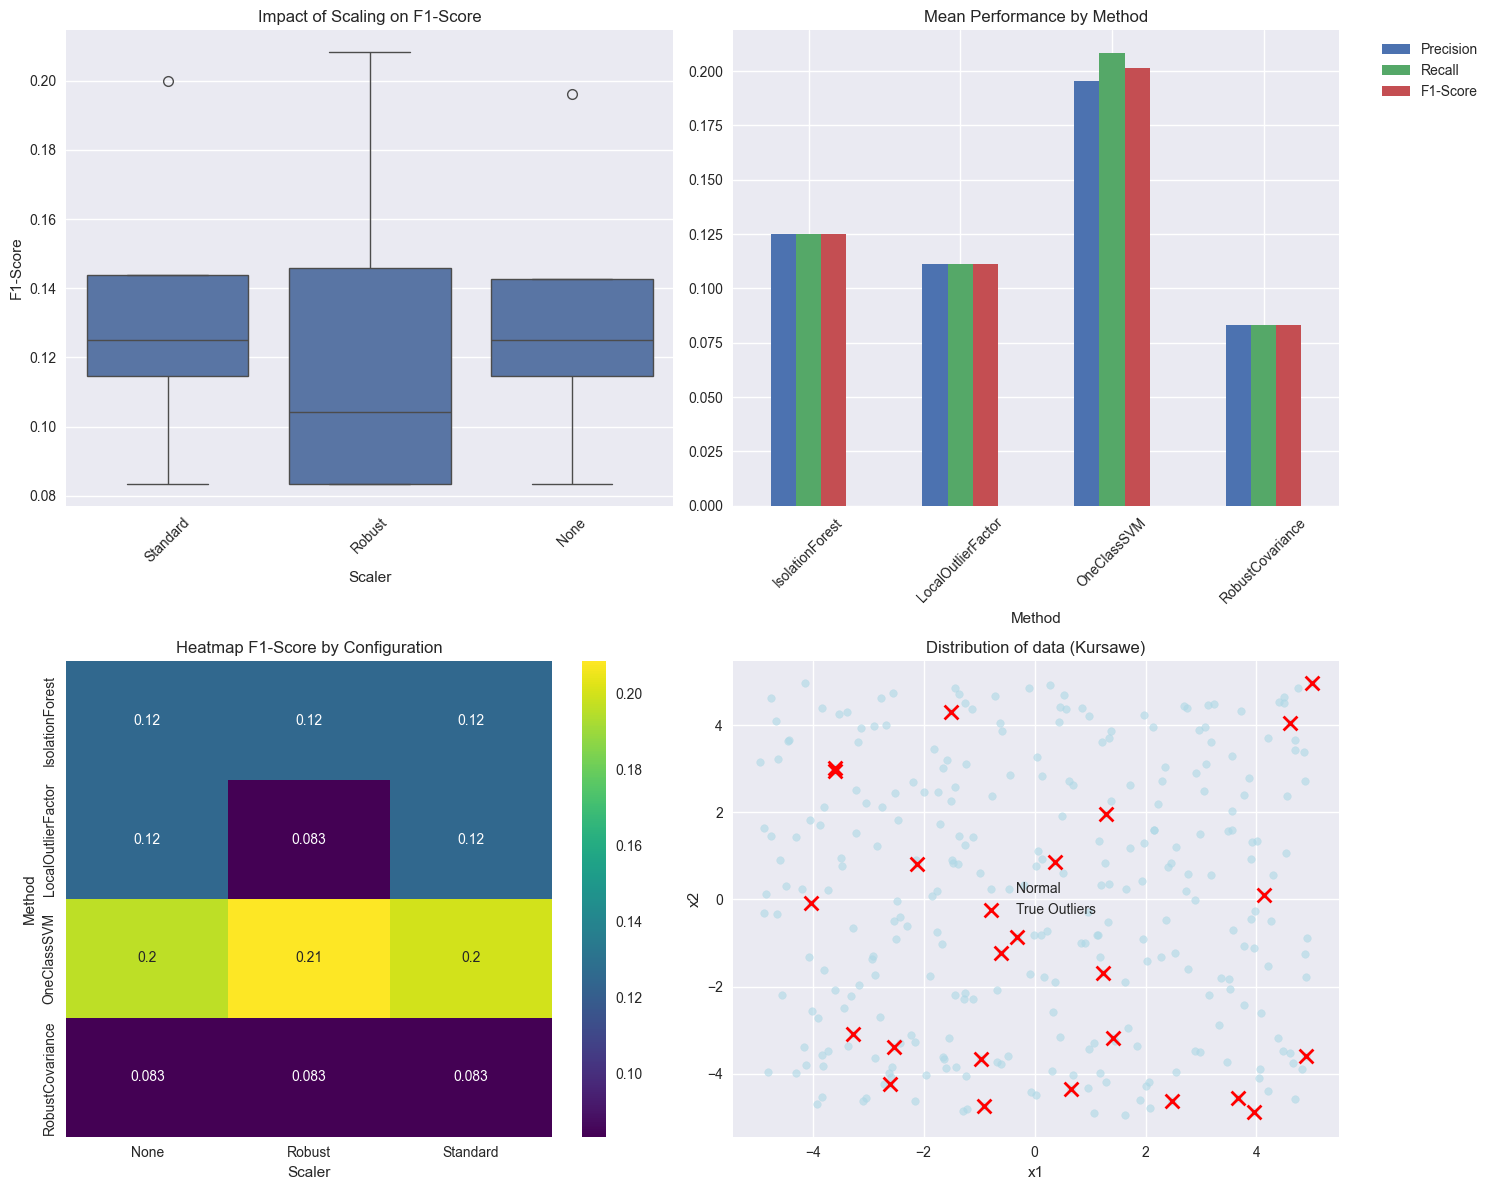

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from pymoo.problems import get_problem
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Generating data with preprocessing
problem = get_problem("kursawe")
N = 5000
X_raw = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))
F = problem.evaluate(X_raw)
y = F[:, 0]

# Outlier injection
frac_outliers = 0.08
n_outliers = int(frac_outliers * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()


noise_levels = np.random.choice([5, 8, 12], size=n_outliers, p=[0.5, 0.3, 0.2])
y_noisy[outlier_idx] += np.random.normal(0, noise_levels)

mask_true_outliers = np.zeros(N, dtype=bool)
mask_true_outliers[outlier_idx] = True

# Data preprocessing
scalers = {
    'Standard': StandardScaler(),
    'Robust': RobustScaler(),
    'None': None
}


def get_improved_detectors(contamination_rate):
    return {
        "IsolationForest_Optimized": IsolationForest(
            contamination=contamination_rate,
            n_estimators=200,          
            max_samples='auto',        
            max_features=1.0,          
            random_state=42,
            bootstrap=False            
        ),
        
        "LocalOutlierFactor_Tuned": LocalOutlierFactor(
            n_neighbors=max(20, int(0.02 * N)),  
            contamination=contamination_rate,
            algorithm='ball_tree',      
            leaf_size=30,
            metric='minkowski',
            p=2,                       
            novelty=False
        ),
        
        "OneClassSVM_Enhanced": OneClassSVM(
            nu=contamination_rate,
            kernel="rbf",
            gamma='scale',             
            tol=1e-4,                 
            shrinking=True,           
            cache_size=1000           
        ),
        
        "RobustCovariance_Improved": EllipticEnvelope(
            contamination=contamination_rate,
            support_fraction=None,     
            random_state=42,
            assume_centered=False,     
            store_precision=True       
        )
    }

# Evaluating different scalers
results = []

for scaler_name, scaler in scalers.items():
    print(f"\n=== Evaluation wither scaler: {scaler_name} ===")
    
    # Preprocessing
    if scaler is not None:
        X_scaled = scaler.fit_transform(X_raw)
    else:
        X_scaled = X_raw.copy()
    
    detectors = get_improved_detectors(frac_outliers)
    
    for name, model in detectors.items():
        try:
            # Prediction
            if "LocalOutlier" in name:
                preds = model.fit_predict(X_scaled)
            else:
                preds = model.fit(X_scaled).predict(X_scaled)
            
            mask_pred = preds == -1
            
            # Compute metrics
            tp = np.sum(mask_pred & mask_true_outliers)
            fp = np.sum(mask_pred & ~mask_true_outliers)
            fn = np.sum(~mask_pred & mask_true_outliers)
            tn = np.sum(~mask_pred & ~mask_true_outliers)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            # AUC probabilities scores
            if hasattr(model, 'decision_function'):
                scores = model.decision_function(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores) 
                scores = model.score_samples(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores)
            else:
                auc = roc_auc_score(mask_true_outliers, mask_pred.astype(int))
            
            results.append({
                "Scaler": scaler_name,
                "Method": name.replace('_Optimized', '').replace('_Tuned', '').replace('_Enhanced', '').replace('_Improved', ''),
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Specificity": specificity,
                "AUC": auc,
                "TP": tp,
                "FP": fp,
                "FN": fn
            })
            
        except Exception as e:
            print(f"Erreur avec {name}: {e}")
            continue

# Results analysis
df_results = pd.DataFrame(results)

# Best configuration for each method
#best_configs = df_results.loc[df_results.groupby('Method')['F1-Score'].idxmax()]
best_configs = df_results

print("\n=== Best Configurations ===")
print(best_configs[['Method', 'Scaler', 'Precision', 'Recall', 'F1-Score', 'AUC']].round(4))


# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance by scaler
sns.boxplot(data=df_results, x='Scaler', y='F1-Score', ax=axes[0,0])
axes[0,0].set_title('Impact of Scaling on F1-Score')
axes[0,0].tick_params(axis='x', rotation=45)

# Performance by method
method_perf = df_results.groupby('Method')[['Precision', 'Recall', 'F1-Score']].mean()
method_perf.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Mean Performance by Method')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=45)

# Heatmap of performances
pivot_f1 = df_results.pivot(index='Method', columns='Scaler', values='F1-Score')
sns.heatmap(pivot_f1, annot=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Heatmap F1-Score by Configuration')

# Distribution of detected outliers
axes[1,1].scatter(X_raw[:, 0], X_raw[:, 1], c='lightblue', s=30, alpha=0.6, label='Normal')
axes[1,1].scatter(X_raw[outlier_idx, 0], X_raw[outlier_idx, 1], 
                 c='red', marker='x', s=100, linewidths=2, label='True Outliers')
axes[1,1].set_title('Distribution of data (Kursawe)')
axes[1,1].set_xlabel('x1')
axes[1,1].set_ylabel('x2')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [12]:


class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim if dim else 2
        self.problem = get_problem(self.name, n_var=self.dim)
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T
    
    def sample_lhs(self, n_points: int):
        sampler = qmc.LatinHypercube(d=self.dim)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def evaluate(self, X):
        return self.problem.evaluate(X)
    
    def inject_outliers(self, X, Y, frac=0.05):
        n_outliers = int(frac * len(Y))
        idx = np.random.choice(len(Y), n_outliers, replace=False)
        Y_noisy = Y.copy()
        Y_noisy[idx] += np.random.normal(10, 5, size=Y_noisy[idx].shape)
        return Y_noisy, idx

In [13]:
class StatisticalOutlierDetection:
    def __init__(self):
        pass
    
    def z_score(self, data, threshold=3.0):
        z_scores = np.abs(stats.zscore(data, axis=0))
        scores = np.max(z_scores, axis=1)
        outliers = scores > threshold
        return outliers, scores

    def iqr(self, data, factor=1.5):
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = np.any((data < lower) | (data > upper), axis=1)
        dist = np.max(np.maximum(0, data - upper) + np.maximum(0, lower - data), axis=1)
        return mask, dist

    def leverage(self, X, threshold=None):
        if X.ndim == 1:
            X = X.reshape(-1,1)
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        if threshold is None:
            threshold = 2 * X_design.shape[1] / X_design.shape[0]
        outliers = leverages > threshold
        return outliers, leverages

    def cooks_distance(self, X, y, threshold=None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        mse = np.mean(residuals**2)
        cooks_d = (residuals**2 / (X.shape[1]*mse)) * (leverages / (1-leverages)**2)
        if threshold is None:
            threshold = 4 / X.shape[0]
        outliers = cooks_d > threshold
        return outliers, cooks_d

    def mahalanobis(self, X, threshold=None):
        cov = EmpiricalCovariance().fit(X)
        m_dist = cov.mahalanobis(X)
        if threshold is None:
            threshold = np.percentile(m_dist, 97.5)  # approx χ² cut
        outliers = m_dist > threshold
        return outliers, m_dist

In [14]:
class MLOutlierDetection:
    def __init__(self):
        pass
    
    def elliptic_envelope(self, X, contamination=0.1):
        model = EllipticEnvelope(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def isolation_forest(self, X, contamination=0.1):
        model = IsolationForest(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def lof(self, X, contamination=0.1, n_neighbors=20):
        model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
        pred = model.fit_predict(X)
        return pred == -1, -model.negative_outlier_factor_

    def one_class_svm(self, X, nu=0.1):
        model = OneClassSVM(gamma="scale", nu=nu)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def sgd_one_class_svm(self, X, nu=0.1):
        try:
            model = SGDOneClassSVM(nu=nu, random_state=42)
            pred = model.fit_predict(X)
            return pred == -1, -model.decision_function(X)
        except Exception as e:
            return np.zeros(X.shape[0], dtype=bool), np.zeros(X.shape[0])

Benchmarking with pymoo:
Rosenbrock 10D -> shape: (128, 1)
First input 5 values: [[-0.61300873  0.0093199  -1.30001298  0.42841766 -1.42220592 -0.90927361
   2.01811534 -0.46903503  1.66075468  0.41639004]
 [ 0.34438687 -0.46016095  0.30614598 -1.68916412  0.89742321  0.28469141
  -1.51948375  1.24371313 -1.99207004 -0.51694692]
 [ 1.18809086  1.77081664 -0.99550489  1.38034213  1.68527802  1.52606154
   0.46709057  0.11967065 -0.03901157 -1.34069363]
 [-1.9454627  -1.83966355  1.98965352 -0.59309176 -0.15412423 -1.89597186
  -0.99044333 -1.40108532  0.40382094  1.68812551]
 [-1.23528648  1.20130547  0.96156724 -0.14670989 -0.86642267 -0.14797289
   0.7130916   0.66221698 -0.72520122 -0.31194328]]
First output 5 values: [[4442.12603184]
 [4421.83703169]
 [2448.02292856]
 [9009.57342967]
 [ 578.19995318]]
